In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score,recall_score, f1_score,precision_score
application = pd.read_csv('E://result//application.csv')
bureau_train = pd.read_csv('E://result//bureau.csv')
credit_card = pd.read_csv('E://result//credit_card_balane.csv')
installments_payments = pd.read_csv('E://result//installments_payments.csv')
POS_CASH_balance = pd.read_csv('E://result//POS_CASH_balance.csv')
previous_application = pd.read_csv('E://result//previous_application.csv')

In [2]:
df_merged = application.merge(bureau_train, on='SK_ID_CURR', how='left')
df_merged = df_merged.merge(credit_card, on='SK_ID_CURR', how='left')
df_merged = df_merged.merge(installments_payments, on='SK_ID_CURR', how='left')
df_merged = df_merged.merge(POS_CASH_balance, on='SK_ID_CURR', how='left')
df_merged = df_merged.merge(previous_application, on='SK_ID_CURR', how='left')

In [5]:
from sklearn.model_selection import train_test_split, KFold
X = df_merged.drop(['TARGET','SK_ID_CURR'], axis=1)
y = df_merged['TARGET']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train.to_csv('E://result//x_train.csv',index=False)
x_test.to_csv('E://result//x_test.csv',index=False)
y_train.to_csv('E://result//y_train.csv',index=False)
y_test.to_csv('E://result//y_test.csv',index=False)

In [67]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

X = df_merged.drop(['TARGET','SK_ID_CURR'], axis=1)  
y = df_merged['TARGET'] 

params = {
    'scale_pos_weight':12,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 100,
    "learning_rate": 0.05,
    "max_bin": 255,
    "n_estimators": 300,
    "colsample_bytree": 0.9, 
    "colsample_bynode": 0.9,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1, 
    "reg_lambda": 3.25, 
    "extra_trees":True,
    "device": "gpu",
}


model = lgb.LGBMClassifier(**params)
scoring = ['precision', 'recall']

model.fit(X, y)
cv_result= cross_validate(model, X, y, cv=5, scoring=scoring)

In [50]:
print(cv_result)

{'fit_time': array([38.81166649, 38.68456268, 48.28334737, 61.51277375, 66.14455724]), 'score_time': array([0.45001721, 0.51900053, 0.87899995, 0.77079868, 0.79299998]), 'test_precision': array([0.18022902, 0.1798412 , 0.18065346, 0.18187888, 0.19652351]), 'test_recall': array([0.7164149 , 0.71621349, 0.70715005, 0.71319235, 0.66263847])}


Accuracy: 0.7645480708258133
Precision: 0.19440882277507054
Recall: 0.6126490200040412
F1 Score: 0.2951569724993916
ROC AUC: 0.7692175149212493


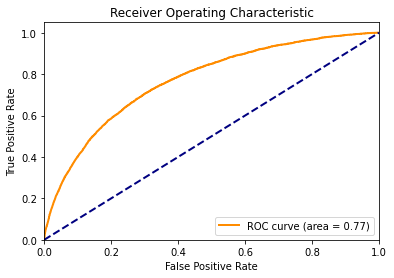

In [60]:
params = {
    'scale_pos_weight':10,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 300,
    "learning_rate": 0.03,
    "max_bin": 255,
    "n_estimators": 100,
    "colsample_bytree": 0.9, 
    "colsample_bynode": 0.9,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1, 
    "reg_lambda": 3.25, 
    "extra_trees":True,
    "device": "gpu"
}

X = df_merged.drop(['TARGET','SK_ID_CURR'], axis=1)
y = df_merged['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_groups = 5  
feature_groups = np.array_split(X_train.columns, n_groups)

kf = KFold(n_splits=5, random_state=42, shuffle=True)

base_models = [LGBMClassifier(**params) for _ in range(n_groups)]
n_estimators = 100  
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
meta_features_train = np.zeros((n_samples_train, len(base_models) * n_estimators))  
meta_features_test = np.zeros((n_samples_test, len(base_models) * n_estimators))  

for train_index, val_index in kf.split(X_train):
    X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]
    for i, (model, features) in enumerate(zip(base_models, feature_groups)):
        model.fit(X_train_kf[features], y_train_kf)
        leaf_indices = model.predict(X_val_kf[features], pred_leaf=True)
        meta_features_train[val_index, i*n_estimators:(i+1)*n_estimators] = leaf_indices
        
for i, (model, features) in enumerate(zip(base_models, feature_groups)):
    model.fit(X_train[features], y_train)
    leaf_indices = model.predict(X_test[features], pred_leaf=True)
    meta_features_test[:, i*n_estimators:(i+1)*n_estimators] = leaf_indices

combined_meta_features_train = np.hstack((X_train.values, meta_features_train))
combined_meta_features_test = np.hstack((X_test.values, meta_features_test))

meta_model = LGBMClassifier(**params)
meta_model.fit(combined_meta_features_train, y_train)

final_predictions = meta_model.predict(combined_meta_features_test)
final_probabilities = meta_model.predict_proba(combined_meta_features_test)[:, 1]  

accuracy = accuracy_score(y_test, final_predictions)
recall = recall_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions)
roc_auc = roc_auc_score(y_test, final_probabilities)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

fpr, tpr, _ = roc_curve(y_test, final_probabilities)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [68]:
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

In [69]:
top_20 = importance_df.iloc[0:20]
top_20 

,Feature,Importance
26,EXT_SOURCE_1,283
28,EXT_SOURCE_3,214
27,EXT_SOURCE_2,179
89,CREDIT_TERM,157
203,AMT_PAYMENT_min,133
3,AMT_ANNUITY,127
79,woe_CODE_GENDER,123
6,DAYS_BIRTH,117
85,woe_ORGANIZATION_TYPE,112
10,OWN_CAR_AGE,108


In [53]:
import plotly.graph_objs as go
import plotly.offline as py
import plotly.graph_objs as go
import plotly.offline as py

data = [go.Scatter(
    x=top_20['Feature'],
    y=top_20['Importance'],
    mode='markers',
    marker=dict(
        size = 25,
        color=top_20['Importance'],
        colorscale='Viridis',  
        showscale=True 
        
    )
)]

layout = go.Layout(
    autosize=True,
    title='Gradient Boosting Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)

py.plot(fig, filename='feature_importance.html')


'feature_importance.html'

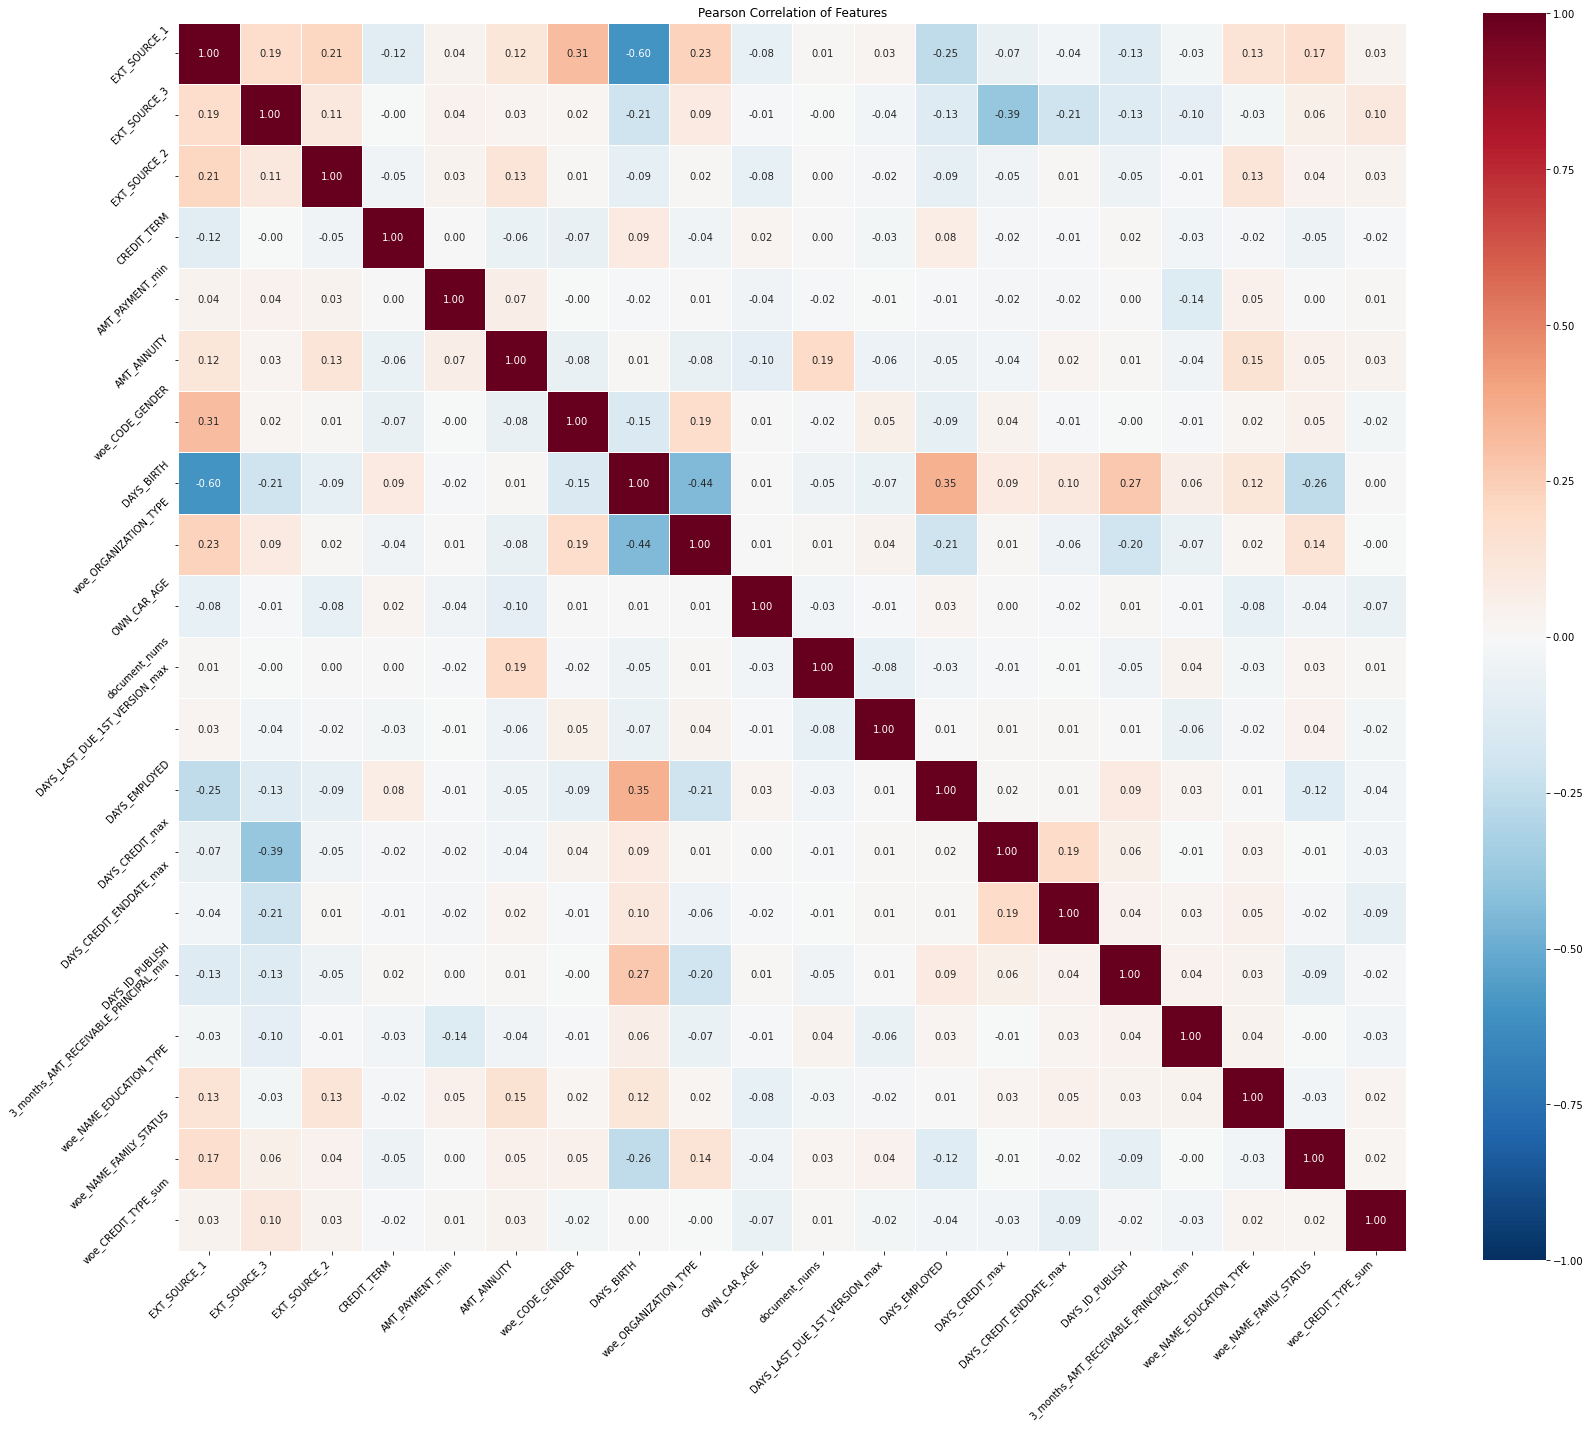

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = X[top_20['Feature']].corr(method='pearson')

plt.figure(figsize=(24, 20))  

ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu_r',
                 vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.title('Pearson Correlation of Features')

plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=45)

plt.tight_layout() 

plt.savefig('image.png', dpi=400)
plt.show()
